In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import PIL
from PIL import Image, ImageOps
import cv2
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json
from utils import *

In [3]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 2019
seed_everything(SEED)

In [4]:
current_time = get_BJ_time()
print(current_time)

0809_01-49-41


# Reading data and Basic EDA(Exploratory Data Analysis)

Here I am going to open the dataset with pandas, check distribution of labels.

In [5]:
df_2015 = pd.read_csv('../input/aptos-data-split/df_2015_raw.csv')
# df_2015.drop(["Unnamed: 0"], axis=1, inplace=True)

df_2019 = pd.read_csv('../input/aptos-data-split/df_2019_sigmaX30.csv')
# df_2019.drop(["Unnamed: 0"], axis=1, inplace=True)

df = pd.concat([df_2015, df_2019]).reset_index(drop=True) # merge train val together
df['is_valid'] = [False]*df_2015.shape[0] + [True]*df_2019.shape[0]

test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [6]:
bs = 32 #smaller batch size is better for training, but may take longer
sz = 256
tfms = get_transforms(do_flip=True,flip_vert=True, max_rotate=0, max_zoom=1.2, max_warp=0)

In [7]:
data = (ImageList.from_df(df=df_2019,path='./',cols='path')
        .split_from_df('is_valid')
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )
data

ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,0.0,1.0,2.0,1.0
Path: .;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,1.0,0.0,4.0,0.0
Path: .;

Test: None

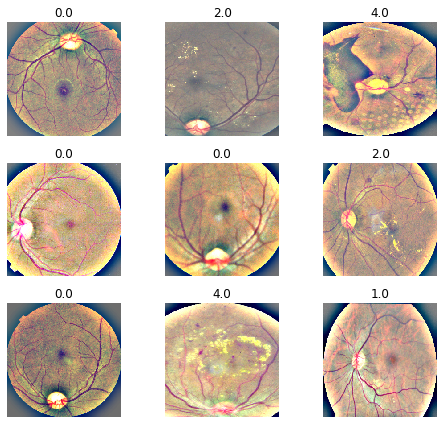

In [8]:
data.show_batch()

# Training (Transfer learning)

The Kaggle competition used the Cohen's quadratically weighted kappa so I have that here to compare. This is a better metric when dealing with imbalanced datasets like this one, and for measuring inter-rater agreement for categorical classification (the raters being the human-labeled dataset and the neural network predictions). Here is an implementation based on the scikit-learn's implementation, but converted to a pytorch tensor, as that is what fastai uses.

In [9]:
def qk(y_pred, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')

**Training:**

Pretrain on augemented data first, take whole competition data as validation set

## ig_resnext101_32x8d_wsl

In [10]:
model_name = "resnext101_32x8d_wsl"

In [17]:
learn = cnn_learner(data, base_arch=md.resnext101_32x8d, metrics = [qk],
                   callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                   model_dir = '../output/models/')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.00E-02


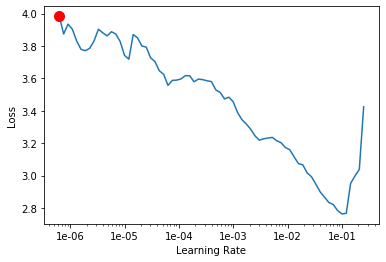

In [12]:
# # Freeze layers up to the last one, so weights will not be updated.
learn.freeze()
        
# # Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [18]:
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,qk,time
0,1.554927,0.737752,0.787401,00:42
1,0.771826,0.473010,0.835707,00:42
2,0.559611,0.322860,0.887119,00:42
3,0.446048,0.306873,0.896083,00:42
4,0.385917,0.288193,0.894430,00:42


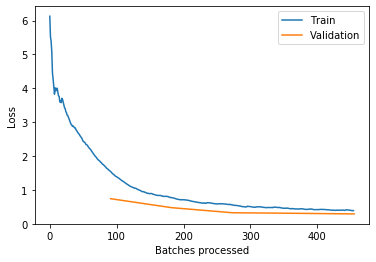

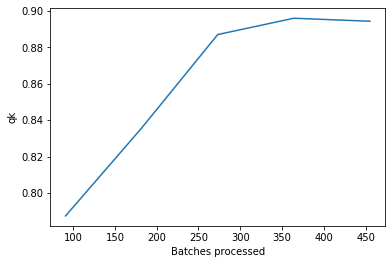

In [19]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.51E-06


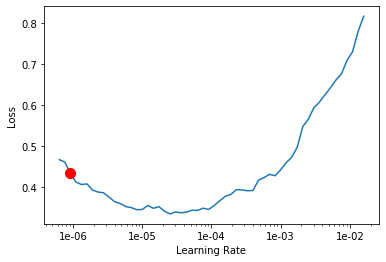

In [20]:
# # Freeze layers up to the last one, so weights will not be updated.
learn.unfreeze()
        
# # Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [ ]:
model_save_name = "{}_{}".format(model_name, current_time)
min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(15, 3e-6, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.346390,0.313937,0.879141,01:03
1,0.364844,0.275986,0.900772,01:03
2,0.367675,0.287677,0.898245,01:03
3,0.335287,0.273125,0.895934,01:03
4,0.337573,0.295619,0.892939,01:03
5,0.313065,0.290801,0.891597,01:03


Better model found at epoch 0 with valid_loss value: 0.31393688917160034.
Better model found at epoch 1 with valid_loss value: 0.2759862244129181.
Better model found at epoch 3 with valid_loss value: 0.2731251120567322.


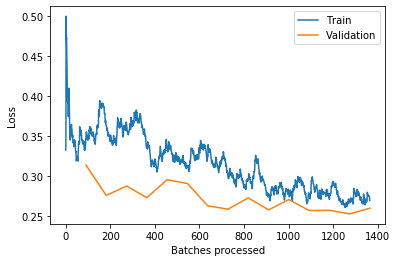

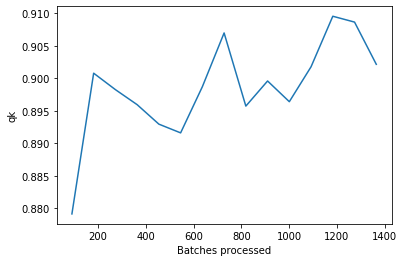

In [23]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 4.79E-07


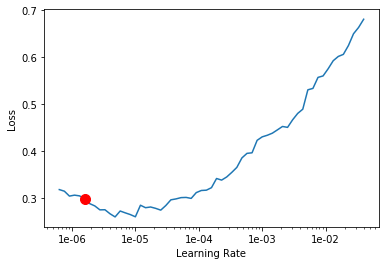

In [25]:
# # Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [26]:
learn.fit_one_cycle(15, 2e-6, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.246416,0.260575,0.900153,01:03
1,0.277404,0.260178,0.898383,01:03
2,0.266334,0.253976,0.905854,01:03
3,0.273735,0.284131,0.887932,01:03
4,0.274282,0.272196,0.893465,01:03
5,0.255489,0.266554,0.900240,01:03


Better model found at epoch 0 with valid_loss value: 0.26057547330856323.
Better model found at epoch 1 with valid_loss value: 0.260177880525589.
Better model found at epoch 2 with valid_loss value: 0.25397589802742004.
Epoch 6: early stopping
Model save as: resnext101_32x8d_wsl_0809_01-49-41


In [27]:
learn.load(model_save_name)

Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,0.0,1.0,2.0,1.0
Path: .;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,1.0,0.0,4.0,0.0
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3

# Optimize the Metric
Optimizing the quadratic kappa metric was an important part of the top solutions in the previous competition. Thankfully, @abhishek has already provided code to do this for us. We will use this to improve the score.

In [28]:
import scipy as sp

In [29]:
class OptimizedRounder(object):
    """
    Optimize threshold coefficients.
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Customized loss function.
        
        :param coef: list, shape=[4]
            Threshold.
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        
        # Cohen's kappa: a statistic that measures inter-annotator agreement.
        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        # new function with partial application of the given arguments and keywords.
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        # Minimization of scalar function of one or more variables.
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        """
        :param X: list, shape=[5]
            Prediction.
        :param coef: list, shape=[4]
            Threshold.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [30]:
# Return predictions and targets on `ds_type` dataset.
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])
coefficients = optR.coefficients()
print(coefficients)

0.9128750059430419
[0.538847 1.471951 2.37918  3.343991]


# Error Analysis

Confusion matrix, without normalization
[[365   3   1   0   0]
 [  1  40  20   0   2]
 [  0  25 154   7  17]
 [  0   0  31  21  28]
 [  0   0   0   2  16]]


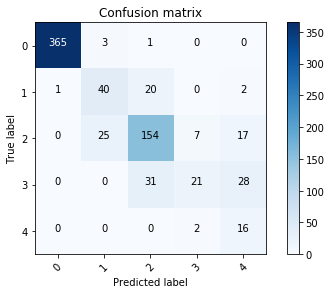

In [31]:
valid_pred = optR.predict(valid_preds[0], [0.5, 1.5, 2.5, 3.5])
cm = confusion_matrix(valid_pred,valid_preds[1])
plot_confusion_matrix(cm, classes=range(5), normalize=False)

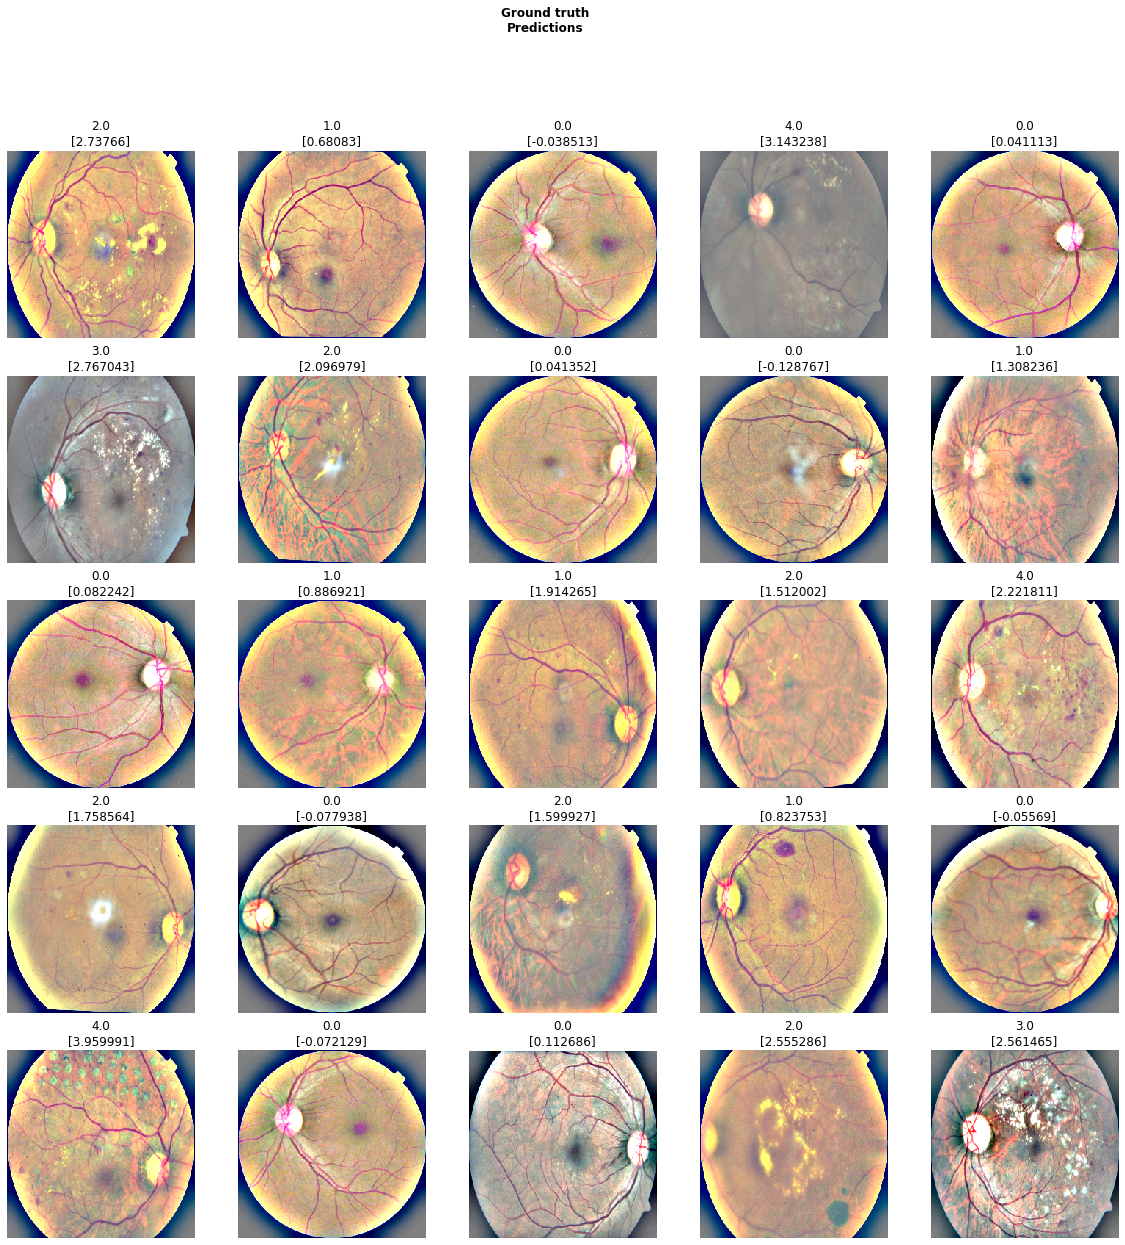

In [32]:
learn.show_results()

# Submission

In [40]:
learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing',
                                      suffix='.png'))

In [41]:
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, coefficients)
test_df.diagnosis = tst_pred.astype(int)

In [42]:
save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

resnext101_32x8d_wsl_0809_01-49-41_submition.csv done


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd118f2c0f0>]], dtype=object)

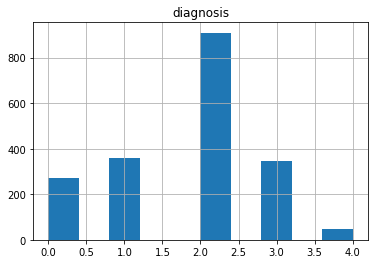

In [43]:
test_df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd185ff4518>]], dtype=object)

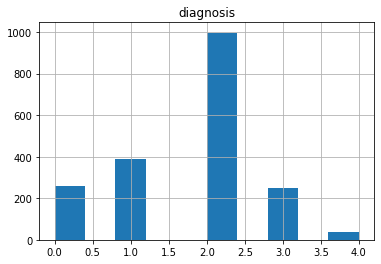

In [44]:
test_df.diagnosis = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd15300f1d0>]], dtype=object)

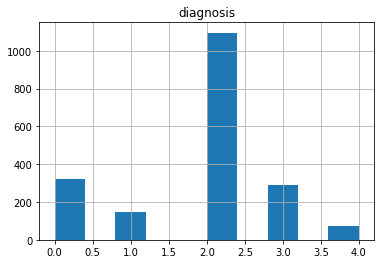

In [45]:
pd.read_csv("0.786.csv").hist()